## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [255]:
import pandas as pd
import numpy as np
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [256]:
# your code here
#1)The kernel after parameter optimization and fitting to the observed data.
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel
#to better fit the model, I will take logarithm and subtract the mean of vector
Data1['Log']=np.log(Data1['AvgDailyTrafficCount'])
Data1['Counts']=Data1['Log']-Data1['Log'].mean()
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount,Log,Counts
0,-80.278366,40.468606,84.0,4.430817,-3.977526
1,-80.162117,40.384598,95.0,4.553877,-3.854466
2,-80.221205,40.366778,97.0,4.574711,-3.833632
3,-80.142455,40.622084,111.0,4.709530,-3.698812
4,-80.131975,40.544915,125.0,4.828314,-3.580029


In [257]:
x_obs = Data1[['Longitude','Latitude']]
y_obs = Data1['Counts']
from sklearn.model_selection import train_test_split
kernel = 1.* RBF(length_scale=1., length_scale_bounds=(1e-3, 1e3)) \
    + WhiteKernel(noise_level=1., noise_level_bounds=(1e-10, 1e10))

gp = GaussianProcessRegressor(kernel=kernel,random_state=1)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(x_obs, y_obs)
print(gp.kernel_)

0.662**2 * RBF(length_scale=0.0355) + WhiteKernel(noise_level=0.567)


In [258]:
#2）The log marginal likelihood of the training data.
print(gp.log_marginal_likelihood_value_)

-1365.9466919139336


/Users/ruijiang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


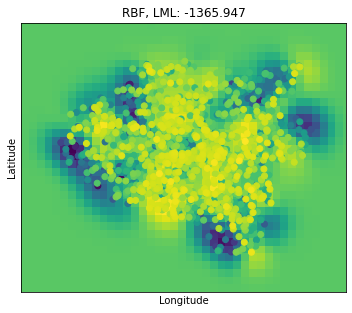

In [259]:
#3） Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). 
X = np.array(x_obs)
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

plt.figure(figsize=(5, 5))
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
plt.subplot(1, 1, 1)
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

y = np.array(y_obs)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("%s, LML: %.3f" %
          ("RBF", gp.log_marginal_likelihood(gp.kernel_.theta)))

plt.tight_layout()
plt.show()

In [260]:
#4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location?
Data1['Predict_traffic'] = gp.predict(Data1[['Longitude','Latitude']])
Data1['Standard_deviation'] = Data1.Predict_traffic.std()
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount,Log,Counts,Predict_traffic,Standard_deviation
0,-80.278366,40.468606,84.0,4.430817,-3.977526,-1.594040,0.527628
1,-80.162117,40.384598,95.0,4.553877,-3.854466,-0.800837,0.527628
2,-80.221205,40.366778,97.0,4.574711,-3.833632,-1.246781,0.527628
3,-80.142455,40.622084,111.0,4.709530,-3.698812,-1.251590,0.527628
4,-80.131975,40.544915,125.0,4.828314,-3.580029,-1.326580,0.527628


In [261]:
sum((Data1.Counts - Data1.Predict_traffic) > Data1.Standard_deviation * 2)

32

In [262]:
sum((Data1.Predict_traffic - Data1.Counts) > Data1.Standard_deviation * 2)

98

In [263]:
Data1.Predict_traffic.count()

1115

In [264]:
#Percentage
(32 + 98) / 1115 *100

11.659192825112108

In [265]:
#5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values.
Data1['Scores'] = (Data1['Counts'] - Data1['Predict_traffic']) / Data1['Standard_deviation']
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount,Log,Counts,Predict_traffic,Standard_deviation,Scores
0,-80.278366,40.468606,84.0,4.430817,-3.977526,-1.594040,0.527628,-4.517359
1,-80.162117,40.384598,95.0,4.553877,-3.854466,-0.800837,0.527628,-5.787461
2,-80.221205,40.366778,97.0,4.574711,-3.833632,-1.246781,0.527628,-4.902790
3,-80.142455,40.622084,111.0,4.709530,-3.698812,-1.251590,0.527628,-4.638157
4,-80.131975,40.544915,125.0,4.828314,-3.580029,-1.326580,0.527628,-4.270903


/Users/ruijiang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


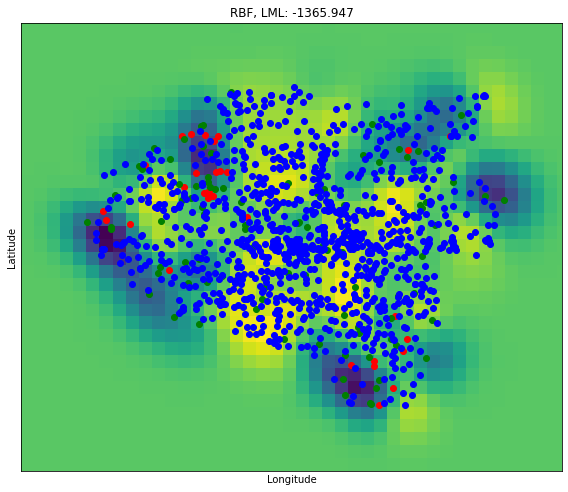

In [266]:
Higher = Data1[Data1['Scores'] > 2]
Lower = Data1[Data1['Scores'] < -2]
Within = Data1[abs(Data1['Scores']) <= 2]
plt.figure(figsize=(8, 8))
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
plt.subplot(1, 1, 1)
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

y = np.array(y_obs)
# Plot also the training points
plt.scatter(Higher['Longitude'], Higher['Latitude'], c='r', label='More than two standard deviations higher than predicted')
plt.scatter(Lower['Longitude'], Lower['Latitude'], c='g', label='Lower than two standard deviations lower than predicted')
plt.scatter(Within['Longitude'], Within['Latitude'], c='b', label='Within two standard deviations of the predicted values')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("%s, LML: %.3f" %
          ("RBF", gp.log_marginal_likelihood(gp.kernel_.theta)))

plt.tight_layout()
plt.show()

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 2 points, center (10, 10), standard deviation 1

B: 200 points, center (15, 20), standard deviation 1

C: 150 points, center (35, 5), standard deviation 5

D: 100 points, center (0, 0), standard deviation 0.1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(10, 11)	Anomaly / Not Anomaly

(15, 19)	Anomaly / Not Anomaly

(35, 2)		Anomaly / Not Anomaly

(1, 0)		Anomaly / Not Anomaly

### Your solutions here
Anomaly; because there is only 2 points in the cluster 

Not Anomaly; because the distance between (15,19) and (15,20) is within 1 standard deviation

Not Anomaly; because the point is within 1 standard deviation

Anomaly; because the point(1,0) is 10 standard deviation away from the center (0,0)

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [267]:
Data2=pd.read_csv("2022CountyHealthIndicators.csv")
Data2.head()

,County,'\% Reporting Fair/Poor Health','\% Low birth weight births','\% Smokers','\% Obese','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking','\% Alcohol-Impaired Driving Deaths','Chlamydia Rate',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",20,10.0,20,35,32,63.0,16,32.0,578.1,...,15.0,5.1,28.0,12.9,272.0,69.0,9.5,15,87.0,41
1,"Baldwin, Alabama",17,8.0,20,30,28,75.0,22,32.0,336.0,...,12.0,4.4,18.0,10.1,204.0,75.0,7.2,12,83.0,38
2,"Barbour, Alabama",31,12.0,28,40,42,50.0,14,38.0,895.2,...,38.0,6.0,54.0,7.3,414.0,82.0,9.0,15,84.0,37
3,"Bibb, Alabama",25,10.0,25,41,38,11.0,16,21.0,540.3,...,22.0,5.4,37.0,8.9,89.0,103.0,9.4,11,88.0,55
4,"Blount, Alabama",23,8.0,22,39,33,23.0,16,15.0,404.7,...,19.0,4.8,23.0,7.4,483.0,105.0,9.4,10,88.0,60


In [269]:
# your code here
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
#Part 1
#as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings
Data2.set_index('County',inplace=True)
data2 = Data2[["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"]]
data2

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
County,,,,,,
"Autauga, Alabama",20,35,272.0,5.1,15.0,9.5
"Baldwin, Alabama",20,30,204.0,4.4,12.0,7.2
"Barbour, Alabama",28,40,414.0,6.0,38.0,9.0
"Bibb, Alabama",25,41,89.0,5.4,22.0,9.4
"Blount, Alabama",22,39,483.0,4.8,19.0,9.4
...,...,...,...,...,...,...
"Sweetwater, Wyoming",17,34,300.0,4.2,8.0,5.4
"Teton, Wyoming",11,22,NaN,3.8,4.0,5.2
"Uinta, Wyoming",19,30,71.0,3.7,10.0,6.9


In [270]:
data2.dtypes

'\% Smokers'                  int64
'\% Obese'                    int64
'Violent Crime Rate'        float64
'80/20 Income Ratio'        float64
'\% Children in Poverty'    float64
'Average Daily PM2.5'       float64
dtype: object

In [274]:
for a in data2.iloc[:,0:6]:
    data2[a] = pd.cut(data2[a],5,labels = False)
print(data2.head())
data2["'\% Smokers'"] = data2["'\% Smokers'"].astype('float64')
data2["'\% Obese'"] = data2["'\% Obese'"].astype('float64')
data2["'Average Daily PM2.5'"] = data2["'Average Daily PM2.5'"].astype('float64')
data2 = data2.dropna()
data2[data2.columns] = data2[data2.columns].astype('int64')
data2.head()

                  '\% Smokers'  '\% Obese'  'Violent Crime Rate'  \
County                                                             
Autauga, Alabama             1           2                   0.0   
Baldwin, Alabama             1           1                   0.0   
Barbour, Alabama             2           3                   1.0   
Bibb, Alabama                2           3                   0.0   
Blount, Alabama              2           3                   1.0   

                  '80/20 Income Ratio'  '\% Children in Poverty'  \
County                                                             
Autauga, Alabama                   2.0                       1.0   
Baldwin, Alabama                   1.0                       0.0   
Barbour, Alabama                   2.0                       3.0   
Bibb, Alabama                      2.0                       1.0   
Blount, Alabama                    1.0                       1.0   

                  'Average Daily PM2.5'  
Coun

/var/folders/gv/bct_w3px54b1tmrt65k0y7d80000gn/T/ipykernel_35610/1333706447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2[a] = pd.cut(data2[a],5,labels = False)
/var/folders/gv/bct_w3px54b1tmrt65k0y7d80000gn/T/ipykernel_35610/1333706447.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2["'\% Smokers'"] = data2["'\% Smokers'"].astype('float64')
/var/folders/gv/bct_w3px54b1tmrt65k0y7d80000gn/T/ipykernel_35610/1333706447.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
County,,,,,,
"Autauga, Alabama",1,2,0,2,1,1
"Baldwin, Alabama",1,1,0,1,0,1
"Barbour, Alabama",2,3,1,2,3,1
"Bibb, Alabama",2,3,0,2,1,1
"Blount, Alabama",2,3,1,1,1,1


In [275]:
#(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure
hc = HillClimbSearch(data2)
best_model = hc.estimate(scoring_method=BicScore(data2))
print(best_model.edges())


  0%|          | 0/1000000 [00:00<?, ?it/s]

[("'\\% Smokers'", "'\\% Children in Poverty'"), ("'\\% Smokers'", "'Average Daily PM2.5'"), ("'\\% Obese'", "'\\% Smokers'"), ("'\\% Children in Poverty'", "'80/20 Income Ratio'"), ("'\\% Children in Poverty'", "'Violent Crime Rate'")]


In [276]:
model = BayesianNetwork(best_model.edges())
model.fit(data2, estimator=MaximumLikelihoodEstimator)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of '\% Smokers':
+-----------------+-----+---------------------+
| '\% Obese'      | ... | '\% Obese'(4)       |
+-----------------+-----+---------------------+
| '\% Smokers'(0) | ... | 0.0                 |
+-----------------+-----+---------------------+
| '\% Smokers'(1) | ... | 0.15789473684210525 |
+-----------------+-----+---------------------+
| '\% Smokers'(2) | ... | 0.5789473684210527  |
+-----------------+-----+---------------------+
| '\% Smokers'(3) | ... | 0.2631578947368421  |
+-----------------+-----+---------------------+
| '\% Smokers'(4) | ... | 0.0                 |
+-----------------+-----+---------------------+
CPD of '\% Children in Poverty':
+-----------------------------+-----+-----------------+
| '\% Smokers'                | ... | '\% Smokers'(4) |
+-----------------------------+-----+-----------------+
| '\% Children in Poverty'(0) | ... | 0.0             |
+-----------------------------+-----+-----------------+
| '\% Children in Poverty'(1) | ... | 0.0 

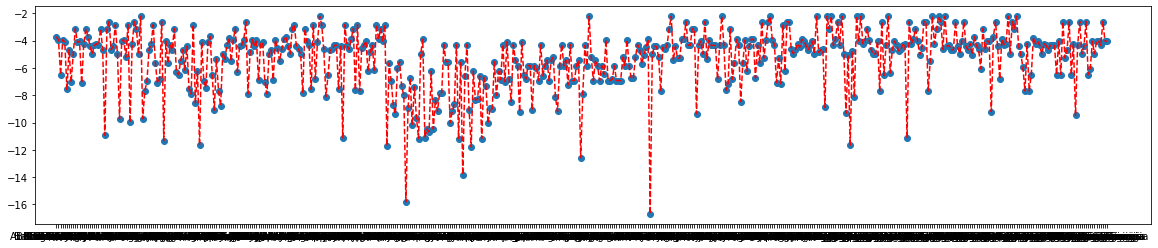

In [310]:
#b)Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values.
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        theparents_list = []
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
            theparents_list.append(parent)
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print(thevariable,theparents_list,theprob)
        loglike += np.log(theprob)
    return loglike
# compute anomalousness of each of the first 500 data records
exmp=data2.iloc[:500,:].apply(lambda x: LL(x,model),axis=1)
import matplotlib.pylab as plt
plt.figure(figsize=(20,4))
plt.scatter(range(len(exmp)),exmp)
plt.xlim(-10,520)
plt.plot(exmp,"r--")
plt.show()

In [309]:
#5 counties and log-likelihood values
print(exmp.sort_values().head())

County
District of Columbia, District of Columbia   -16.698151
Fresno, California                           -15.809304
San Joaquin, California                      -13.812674
Mineral, Colorado                            -12.567524
Shasta, California                           -11.775510
dtype: float64


In [300]:
#Part 2
# (a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances.
Data3=pd.read_csv("2022CountyHealthIndicators.csv")
Data3.set_index('County',inplace=True)
data3 = Data3[["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"]]
data3 = data3.dropna()
from sklearn.cluster import KMeans
KM=KMeans(n_clusters=3,random_state=999)
scor=KM.fit_predict(data3)

# distance to each cluster center
res=pd.DataFrame(KM.transform(data3))
res.head()

,0,1,2
0,85.230478,139.285835,449.539221
1,153.400401,71.614621,517.636401
2,60.218918,282.220833,307.799521
3,268.128066,44.739202,632.456074
4,126.010032,350.298273,238.507506


In [301]:
# add cluster and distance information for each data record
res=pd.DataFrame(KM.transform(data3))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(data3))),axis=1)
res.columns=list(range(3))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

# find data records farthest from cluster centers
res.sort_values("score",ascending=False)[:5]

,0,1,2,cluster,score
1452,1462.986999,1687.309294,1098.586470,2,1098.586470
1125,1208.980212,1433.303308,844.580064,2,844.580064
365,1142.110090,1366.442170,777.709587,2,777.709587
1058,1021.041101,1245.373022,656.630206,2,656.630206
2313,988.983710,1213.309065,624.581071,2,624.581071


In [302]:
res.set_index(data3.index, inplace = True)
res.sort_values('score', ascending = False) [:5]

,0,1,2,cluster,score
County,,,,,
"St. Louis City, Missouri",1462.986999,1687.309294,1098.586470,2,1098.586470
"Baltimore City, Maryland",1208.980212,1433.303308,844.580064,2,844.580064
"Calhoun, Georgia",1142.110090,1366.442170,777.709587,2,777.709587
"Ouachita, Louisiana",1021.041101,1245.373022,656.630206,2,656.630206
"Shelby, Tennessee",988.983710,1213.309065,624.581071,2,624.581071


In [303]:
# (b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness.
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=3,random_state=999)
GM.fit(data3)

GaussianMixture(n_components=3, random_state=999)

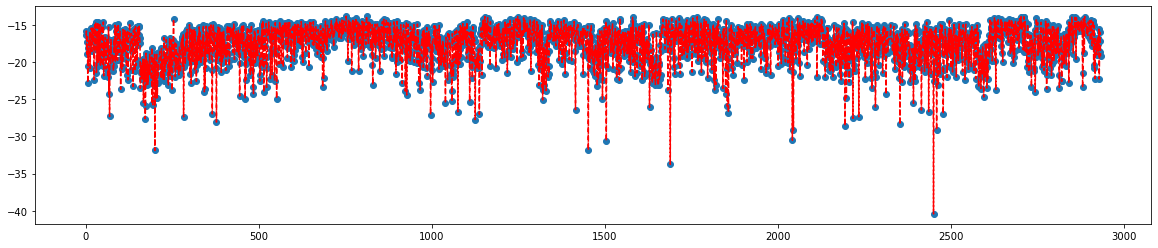

In [304]:
# score_samples function gives the log of the probability density of each data record given its cluster.
# Note that probability densities can exceed 1 (unlike probabilities of discrete data).
import matplotlib.pylab as plt
plt.figure(figsize=(20,4))
plt.scatter(range(len(data3)),GM.score_samples(data3))
plt.plot(GM.score_samples(data3),"r--")
plt.show()

In [305]:
# 5 most anomalous data
GM_loglikelihood=pd.DataFrame(GM.score_samples(data3))
GM_loglikelihood.set_index(data3.index, inplace = True)
GM_loglikelihood.sort_values(0)[:5]

,0
County,
"Jeff Davis, Texas",-40.436084
"New York, New York",-33.754881
"Siskiyou, California",-31.895735
"St. Louis City, Missouri",-31.841331
"Wheatland, Montana",-30.586671


In [306]:
# Part 3 Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.
from sklearn.neighbors import LocalOutlierFactor
# fit the model
clf = LocalOutlierFactor(n_neighbors=20, novelty=True)
y_pred = clf.fit(data3)._predict()
lof = pd.DataFrame(clf.decision_function(data3))
lof.set_index(data3.index, inplace = True)
lof.sort_values(0)[:5]

/Users/ruijiang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


,0
County,
"St. Louis City, Missouri",-2.038949
"Jeff Davis, Texas",-1.239734
"Baltimore City, Maryland",-0.975026
"Calhoun, Georgia",-0.752359
"Tensas, Louisiana",-0.661196


In [ ]:
# Part 4 Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous.

K-means: St. Louis City, Missouri; Baltimore City, Maryland; Calhoun, Georgia; Ouachita, Louisiana; Shelby, Tennessee.

Gaussian Mixture: Jeff Davis, Texas; New York, New York; Siskiyou, California; St. Louis City, Missouri; Wheatland, Montana.

Yes, there are some counties that were found to be anomalous in some model and not in others. For K-means model and Gaussian Mixture model, they all have anomalous data in St. Louis City, Missouri and Jeff Davis, Texas. I think counties that was found to be anomalous is because high population or high density.